# 🏦 Money Mule Detection — Exploratory Data Analysis

### 👥 Team: Slytherin Ambition  
**Members:**  
- Shatakshi Chauhan 
- Siddharth Chandra  
- Sakshi Pandey
- Stuti Agarwal

---

## 🎯 Objective
This analysis explores banking transaction data to identify behavioral patterns associated with **money mule accounts**.

We investigate:

✔ customer & account risk indicators  
✔ transaction behavior anomalies  
✔ mule activity patterns  
✔ suspicious financial flows  

---


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


## 📂 Dataset Overview

The dataset consists of multiple relational tables:

| Dataset | Description |
|--------|------------|
| Customers | Demographics & KYC details |
| Accounts | Account status & balances |
| Transactions | 5 years of transaction activity |
| Linkage | Customer ↔ Account mapping |
| Product Details | Financial product holdings |
| Labels | Known mule accounts |

---

### 🔗 Entity Relationships

Customers → Accounts → Transactions  
Customers → Product Holdings  
Accounts → Mule Labels

---


In [46]:
DATA_PATH = "C:\\Users\\Lenovo\\Downloads\\IITD-Tryst-Hackathon\\dataset\\"  
customers = pd.read_csv(DATA_PATH + "customers.csv")
accounts = pd.read_csv(DATA_PATH + "accounts.csv")
linkage = pd.read_csv(DATA_PATH + "customer_account_linkage.csv")
products = pd.read_csv(DATA_PATH + "product_details.csv")
labels = pd.read_csv(DATA_PATH + "train_labels.csv")


In [3]:
import glob

files = glob.glob(DATA_PATH + "transactions_part_*.csv")
transactions = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print("Transactions loaded:", transactions.shape)


Transactions loaded: (7424845, 8)


## 🔍 Data Quality Assessment

Before analysis, we evaluate:

✔ missing values  
✔ datatype consistency  
✔ duplicate records  
✔ outlier detection  

Ensuring data quality is critical for reliable risk analysis.


In [4]:
customers.info()
accounts.info()
transactions.info()
customers.isnull().sum()
accounts.isnull().sum()
transactions.isnull().sum()


<class 'pandas.DataFrame'>
RangeIndex: 39988 entries, 0 to 39987
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              39988 non-null  str  
 1   date_of_birth            39988 non-null  str  
 2   relationship_start_date  39988 non-null  str  
 3   pan_available            34256 non-null  str  
 4   aadhaar_available        30280 non-null  str  
 5   passport_available       39988 non-null  str  
 6   mobile_banking_flag      39988 non-null  str  
 7   internet_banking_flag    39988 non-null  str  
 8   atm_card_flag            39988 non-null  str  
 9   demat_flag               39988 non-null  str  
 10  credit_card_flag         39988 non-null  str  
 11  fastag_flag              39988 non-null  str  
 12  customer_pin             39988 non-null  int64
 13  permanent_pin            39988 non-null  int64
dtypes: int64(2), str(12)
memory usage: 4.3 MB
<class 'pandas.DataFram

transaction_id           0
account_id               0
transaction_timestamp    0
mcc_code                 0
channel                  0
amount                   0
txn_type                 0
counterparty_id          0
dtype: int64

## 🔗 Data Integration

We combine customer, account, and product data to enable account-level behavioral analysis.


In [5]:
master = linkage.merge(customers, on="customer_id", how="left") \
                .merge(accounts, on="account_id", how="left") \
                .merge(products, on="customer_id", how="left") \
                .merge(labels[['account_id','is_mule']], on="account_id", how="left")

master.head()


,customer_id,account_id,date_of_birth,relationship_start_date,pan_available,aadhaar_available,passport_available,mobile_banking_flag,internet_banking_flag,atm_card_flag,demat_flag,credit_card_flag,fastag_flag,customer_pin,permanent_pin,account_status,product_code,currency_code,account_opening_date,branch_code,branch_pin,avg_balance,product_family,nomination_flag,cheque_allowed,cheque_availed,num_chequebooks,last_mobile_update_date,kyc_compliant,last_kyc_date,rural_branch,monthly_avg_balance,quarterly_avg_balance,daily_avg_balance,freeze_date,unfreeze_date,loan_sum,loan_count,cc_sum,cc_count,od_sum,od_count,ka_sum,ka_count,sa_sum,sa_count,is_mule
0,CUST_000001,ACCT_000001,1992-12-26,2008-04-09,Y,Y,N,Y,Y,Y,N,Y,N,613004,613004,active,100,1,2023-04-25,8229,613004.0,1526.01,S,N,Y,N,0,NaN,N,2022-04-13,N,1663.31,1830.69,1950.13,NaN,NaN,NaN,0,-75964.52,1,0.00,0,0.0,0,1526.01,1,0.0
1,CUST_000006,ACCT_000006,1950-05-01,2005-08-01,Y,Y,N,Y,N,Y,N,N,Y,400106,400106,active,1133,1,2021-07-01,6076,400106.0,-1048.82,O,N,N,N,0,NaN,Y,2022-04-12,N,-910.01,-1136.48,-1208.54,NaN,NaN,NaN,0,NaN,0,-52331.47,1,0.0,0,0.00,0,0.0
2,CUST_000041,ACCT_000041,1992-01-01,2013-11-22,NaN,N,N,Y,Y,N,N,N,N,700152,700152,active,100,1,2023-07-26,3756,110128.0,0.00,S,N,Y,N,0,NaN,Y,2023-02-07,N,0.00,0.00,0.00,NaN,NaN,NaN,0,NaN,0,0.00,0,0.0,0,0.00,1,0.0
3,CUST_000051,ACCT_000051,1957-01-25,2020-08-12,NaN,Y,N,N,Y,N,N,N,N,400102,380012,active,100,1,2021-11-01,1571,400102.0,7338.07,S,Y,Y,Y,2,NaN,Y,2024-05-02,N,6726.84,5549.71,8654.54,NaN,NaN,NaN,0,NaN,0,0.00,0,0.0,0,7338.07,1,0.0
4,CUST_000059,ACCT_000059,1987-05-08,2023-10-17,Y,Y,Y,N,Y,Y,N,N,N,121012,121012,active,169,1,2023-04-15,8585,121012.0,12472.12,S,Y,Y,Y,0,NaN,Y,2025-01-12,N,14583.24,9026.30,15780.59,NaN,NaN,NaN,0,NaN,0,0.00,0,0.0,0,12472.12,1,0.0


## 👤 Customer Risk Profile Analysis

We explore demographic and KYC indicators.

Questions:
- Is incomplete KYC associated with higher risk?
- Does digital banking adoption vary?
- Are certain age groups more represented?


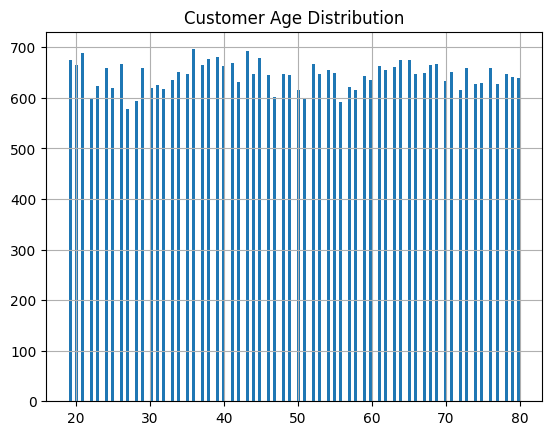

In [6]:
customers['date_of_birth'] = pd.to_datetime(customers['date_of_birth'])
customers['age'] = 2025 - customers['date_of_birth'].dt.year

customers['age'].describe()

customers['age'].hist(bins=150)
plt.title("Customer Age Distribution")
plt.show()


In [7]:
kyc_cols = ['pan_available','aadhaar_available','passport_available']

for col in kyc_cols:
    print(col, (customers[col]=='Y').mean())


pan_available 0.8305991797539262
aadhaar_available 0.4725417625287586
passport_available 0.17837851355406623


## 🏦 Account Behavior Analysis

We evaluate:

✔ account age  
✔ balance distribution  
✔ freeze history  
✔ KYC compliance  

New or unstable accounts may indicate elevated risk.


In [8]:
accounts['account_opening_date'] = pd.to_datetime(accounts['account_opening_date'])
accounts['account_age_days'] = (pd.Timestamp.today() - accounts['account_opening_date']).dt.days

accounts['account_age_days'].describe()


count    40038.000000
mean      1349.874344
std        814.033759
min        242.000000
25%        870.000000
50%       1036.000000
75%       1547.000000
max       3882.000000
Name: account_age_days, dtype: float64

In [25]:
# Check for multiple account ownership
multi_account_check = linkage.groupby('customer_id')['account_id'].count().sort_values(ascending=False)
print(f"Top account count per customer: \n{multi_account_check.head(5)}")

Top account count per customer: 
customer_id
CUST_035891    2
CUST_017236    2
CUST_073739    2
CUST_000809    2
CUST_026184    2
Name: account_id, dtype: int64


In [9]:
digital_cols = ['mobile_banking_flag','internet_banking_flag']

for col in digital_cols:
    print(col, (customers[col]=='Y').mean())


mobile_banking_flag 0.3184705411623487
internet_banking_flag 0.47021606481944583


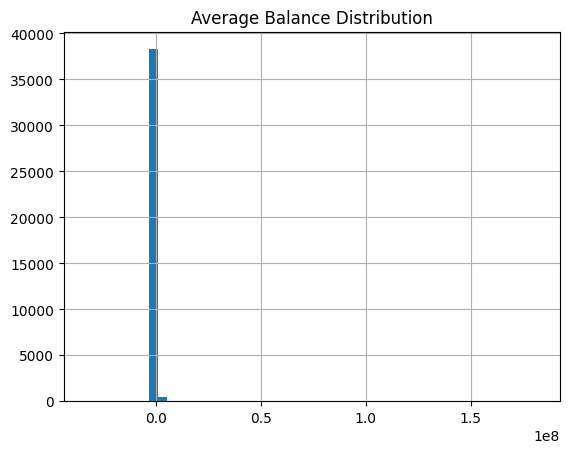

In [10]:
accounts['avg_balance'].describe()

accounts['avg_balance'].hist(bins=50)
plt.title("Average Balance Distribution")
plt.show()


In [11]:
accounts['freeze_date'] = pd.to_datetime(accounts['freeze_date'], errors='coerce')

print("Frozen accounts ratio:", accounts['freeze_date'].notnull().mean())


Frozen accounts ratio: 0.03289375093661022


In [12]:
transactions['transaction_timestamp'] = pd.to_datetime(transactions['transaction_timestamp'])

transactions.sort_values(['account_id','transaction_timestamp'], inplace=True)


In [13]:
print(transactions['txn_type'].value_counts().head(10))

transactions['channel'].value_counts().head(10)


txn_type
D    3996377
C    3428468
Name: count, dtype: int64


channel
UPC    2843619
UPD    2669010
IPM     300057
P2A     208118
END     179307
NTD     139763
FTD      93023
STD      77774
MCR      74608
RCD      73978
Name: count, dtype: int64

In [14]:
transactions['round_amount'] = transactions['amount'] % 1000 == 0
print("Round amount ratio:", transactions['round_amount'].mean())


Round amount ratio: 0.17192776414861186


In [15]:
near_50k = transactions[(transactions['amount'] > 49000) & (transactions['amount'] < 50000)]
print("Near 50K transactions:", len(near_50k))


Near 50K transactions: 8283


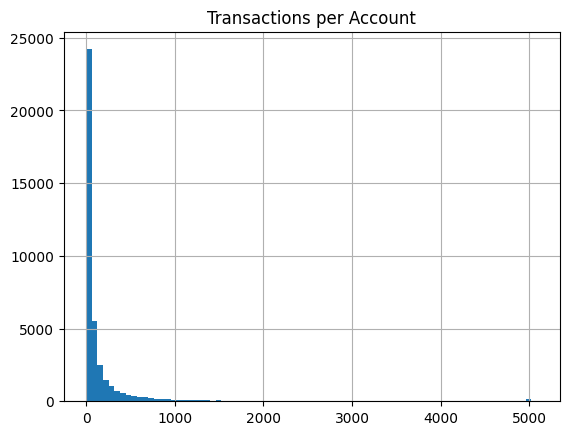

In [16]:
txn_count = transactions.groupby('account_id').size()

txn_count.describe()

txn_count.hist(bins=80)
plt.title("Transactions per Account")
plt.show()


In [17]:
counterparty_counts = transactions.groupby('account_id')['counterparty_id'].nunique()

counterparty_counts.describe()


count    39605.000000
mean        13.921752
std         14.090693
min          1.000000
25%          5.000000
50%         10.000000
75%         18.000000
max        156.000000
Name: counterparty_id, dtype: float64

In [18]:
txn_types = transactions.pivot_table(
    index='account_id',
    columns='txn_type',
    values='amount',
    aggfunc='count',
    fill_value=0
)

txn_types['credit_debit_ratio'] = txn_types['C'] / (txn_types['D'] + 1)
txn_types.head()


txn_type,C,D,credit_debit_ratio
account_id,,,
ACCT_000001,4,6,0.571429
ACCT_000006,46,47,0.958333
ACCT_000041,44,48,0.897959
ACCT_000051,73,80,0.901235
ACCT_000059,74,106,0.691589


In [26]:
# 1. Aggregate features at the account level
txn_features = transactions.groupby('account_id').agg({
    'amount':['count','sum','mean'],
    'counterparty_id':'nunique'
}).reset_index()
txn_features.columns = ['account_id','txn_count', 'txn_sum', 'txn_avg', 'unique_counterparties']

# 2. DEFINE 'analysis' by merging with labels
# This step must run before you can use the 'analysis' variable
analysis = txn_features.merge(labels[['account_id','is_mule']], on='account_id')

# 3. Perform the comparison
print(analysis.groupby('is_mule').mean(numeric_only=True))

          txn_count       txn_sum       txn_avg  unique_counterparties
is_mule                                                               
0        189.001660  1.784383e+06  10060.179220              13.664468
1        197.027132  3.151665e+06  26494.686368              37.104651


In [19]:
txn_features = transactions.groupby('account_id').agg({
    'amount':['count','sum','mean'],
    'counterparty_id':'nunique'
}).reset_index()

txn_features.columns = ['account_id','txn_count','txn_sum','txn_avg','unique_counterparties']


In [20]:
analysis = txn_features.merge(labels[['account_id','is_mule']], on='account_id')

analysis.groupby('is_mule').mean(numeric_only=True)



,txn_count,txn_sum,txn_avg,unique_counterparties
is_mule,,,,
0,189.001660,1.784383e+06,10060.179220,13.664468
1,197.027132,3.151665e+06,26494.686368,37.104651


In [36]:
transactions['transaction_timestamp'] = pd.to_datetime(transactions['transaction_timestamp'])
transactions = transactions.sort_values(['account_id','transaction_timestamp'])

transactions['next_txn_type'] = transactions.groupby('account_id')['txn_type'].shift(-1)
transactions['next_time'] = transactions.groupby('account_id')['transaction_timestamp'].shift(-1)

transactions['retention_minutes'] = (
    transactions['next_time'] - transactions['transaction_timestamp']
).dt.total_seconds() / 60

retention = transactions[
    (transactions['txn_type'] == 'C') &
    (transactions['next_txn_type'] == 'D') &
    (transactions['retention_minutes'] >= 0)
]


In [40]:
retention.columns

Index(['transaction_id', 'account_id', 'transaction_timestamp', 'mcc_code',
       'channel', 'amount', 'txn_type', 'counterparty_id', 'round_amount',
       'next_amount', 'next_time', 'time_diff_min', 'date', 'month',
       'next_txn_type', 'retention_minutes'],
      dtype='str')

In [41]:
retention = retention.merge(
    labels[['account_id','is_mule']],
    on='account_id',
    how='left'
)


## 🔥 Feature Correlation with Mule Behavior

This heatmap shows how engineered behavioral features relate to mule account activity.

### Key Behavioral Signatures

**Liquidation Ratio**
→ measures rapid fund pass-through behavior.

**Dormancy Days**
→ identifies sleeper accounts activated for laundering.

**Counterparty Churn**
→ detects layering via diverse fund routing.

Stronger correlations indicate features that effectively distinguish mule accounts from legitimate users.


## 🚨 Behavioral Indicators: Mule vs Legitimate Accounts

The table below summarizes key behavioral differences observed between legitimate accounts and mule accounts.

| Behavioral Metric | Legitimate Account (0) | Mule Account (1) | Risk Significance |
|------------------|------------------------|------------------|------------------|
| **Fund Retention** | High (Days to Weeks) | Low (Minutes to Hours) | Indicates rapid **pass-through behavior** where funds are quickly moved to avoid detection. |
| **Log Scale Spread** | Diverse, multi-modal distribution | Concentrated at lower durations | Highlights the high **velocity of illicit fund movement**. |
| **Counterparty Churn** | Low (repeated utilities, payroll, known contacts) | High (many new/unique counterparties) | Suggests **layering behavior** used to obscure money trails. |
| **Amount Distribution** | Normal variance based on spending patterns | Spikes near ₹50,000 thresholds | Indicates **structuring ("smurfing")** to evade AML reporting triggers. |

### 🔎 Interpretation
These behavioral signals align with known anti-money laundering (AML) typologies and help distinguish mule accounts from legitimate customer activity.


In [60]:
# --- High-Impact AML Feature Engineering ---

# 1️⃣ Liquidation Ratio (Pass-Through Signature)
txn_sums = transactions.pivot_table(
    index='account_id',
    columns='txn_type',
    values='amount',
    aggfunc='sum',
    fill_value=0
)

txn_sums['liquidation_ratio'] = txn_sums['D'] / (txn_sums['C'] + 0.01)


# 2️⃣ Dormancy Wake-up (Sleeper Signature)
first_txn = transactions.groupby('account_id')['transaction_timestamp'].min().reset_index()

first_txn = first_txn.merge(
    accounts[['account_id', 'account_opening_date']],
    on='account_id'
)

first_txn['account_opening_date'] = pd.to_datetime(first_txn['account_opening_date'])

first_txn['dormancy_days'] = (
    first_txn['transaction_timestamp'] -
    first_txn['account_opening_date']
).dt.days


# 3️⃣ Counterparty Churn (Layering Signature)
counterparty_churn = transactions.groupby('account_id').agg(
    unique_cp=('counterparty_id', 'nunique'),
    total_txns=('amount', 'count')
)

counterparty_churn['cp_churn_ratio'] = (
    counterparty_churn['unique_cp'] /
    counterparty_churn['total_txns']
)


# ✅ Merge features into analysis dataframe
analysis = analysis.merge(txn_sums['liquidation_ratio'], on='account_id', how='left')
analysis = analysis.merge(first_txn[['account_id','dormancy_days']], on='account_id', how='left')
analysis = analysis.merge(counterparty_churn['cp_churn_ratio'], on='account_id', how='left')



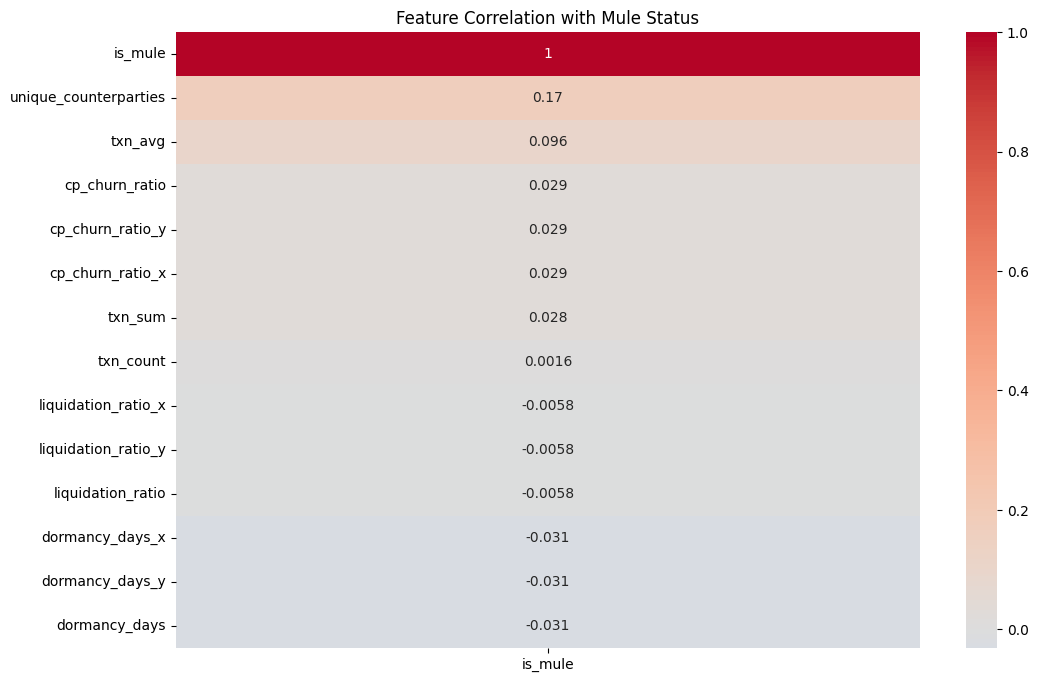

In [61]:

# --- Correlation Heatmap ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

corr = analysis.corr(numeric_only=True)[['is_mule']].sort_values(by='is_mule', ascending=False)

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

plt.title("Feature Correlation with Mule Status")
plt.show()


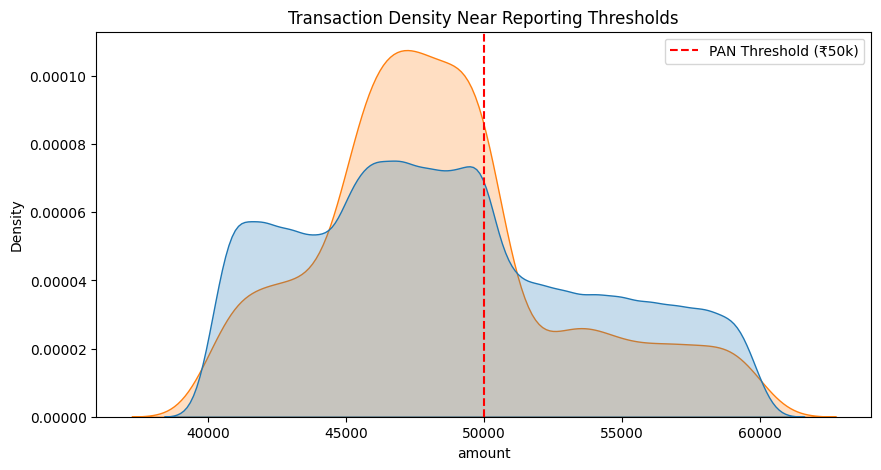

In [62]:
# Focus on the 'Structuring' zone
structuring_data = transactions[(transactions['amount'] > 40000) & (transactions['amount'] < 60000)]
plt.figure(figsize=(10, 5))
sns.kdeplot(data=structuring_data.merge(labels, on='account_id'), 
            x='amount', hue='is_mule', common_norm=False, fill=True)
plt.axvline(50000, color='red', linestyle='--', label='PAN Threshold (₹50k)')
plt.title("Transaction Density Near Reporting Thresholds")
plt.legend()
plt.show()

## 📊 Retentión Time by Account Type

This boxplot compares fund retention time between legitimate accounts (0) and mule accounts (1).

### How to Read
- The central line represents the median retention time.
- The box shows the middle 50% of values.
- Whiskers represent variability outside the quartiles.

### Observations
- Mule accounts show a lower median retention time.
- Legitimate accounts tend to retain funds for longer durations.
- The spread indicates greater variability in legitimate account behavior.

### Interpretation
Shorter retention times in mule accounts suggest rapid fund transfers designed to minimize detection risk.


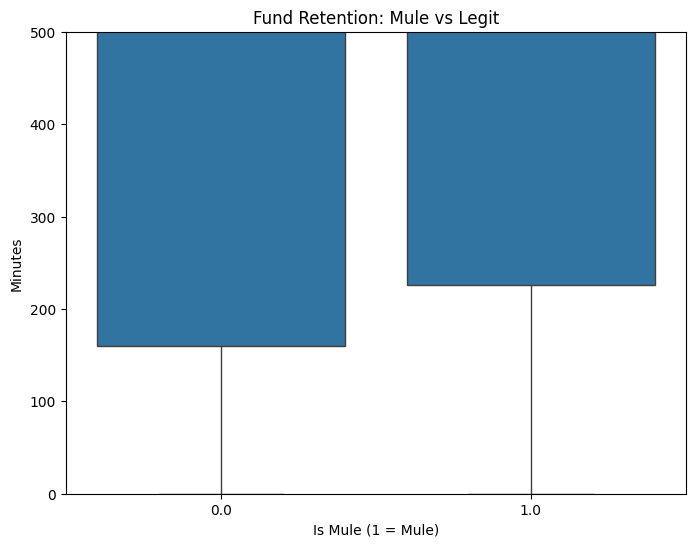

In [45]:
plt.figure(figsize=(8,6))
sns.boxplot(x='is_mule', y='retention_minutes', data=retention)

plt.ylim(0, 500)
plt.title("Fund Retention: Mule vs Legit")
plt.xlabel("Is Mule (1 = Mule)")
plt.ylabel("Minutes")
plt.show()


## 📊 Average Retention Time Comparison

This chart compares the average retention time between mule and legitimate accounts.

### Observations
- Mule accounts exhibit shorter average retention times.
- Legitimate accounts show longer average retention durations.

### Interpretation
This reinforces the rapid pass-through behavior observed in mule accounts.

> Note: Distribution-based plots (e.g., boxplots) provide deeper insights than averages alone.


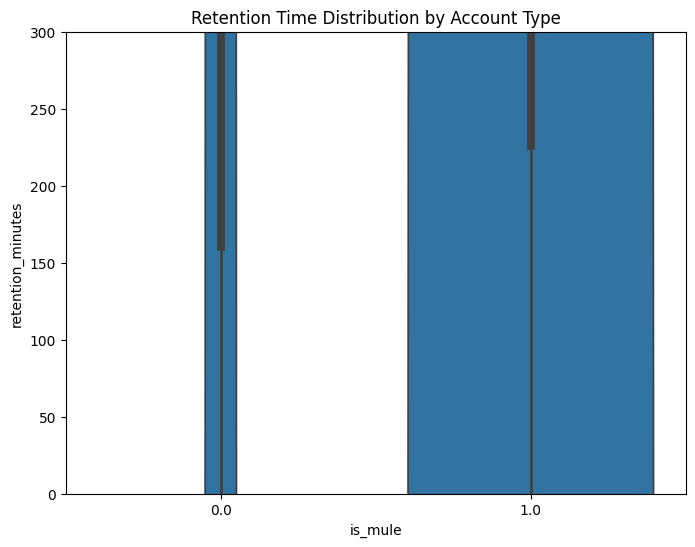

In [43]:
plt.figure(figsize=(8,6))
sns.violinplot(x='is_mule', y='retention_minutes', data=retention)

plt.ylim(0, 300)
plt.title("Retention Time Distribution by Account Type")
plt.show()


## 📈 Daily Transaction Volume Trend

This time-series plot shows the total number of transactions processed each day over the observation period.

### Why This Matters
Monitoring daily transaction volume helps identify unusual spikes, burst activity, or abnormal transaction patterns.

### Observations
- Most days show stable transaction volumes reflecting normal banking activity.
- Noticeable spikes indicate sudden surges in activity.
- These bursts may represent coordinated transfers or rapid fund movement.

### Interpretation
Sudden increases in daily transaction volume may signal:

• dormant accounts becoming active  
• rapid fund routing through mule networks  
• coordinated laundering activity  
• short-term transaction bursts to avoid detection  

### Risk Insight
Unusual spikes in transaction volume are consistent with mule account behavior, where funds are rapidly moved through accounts within short time windows.


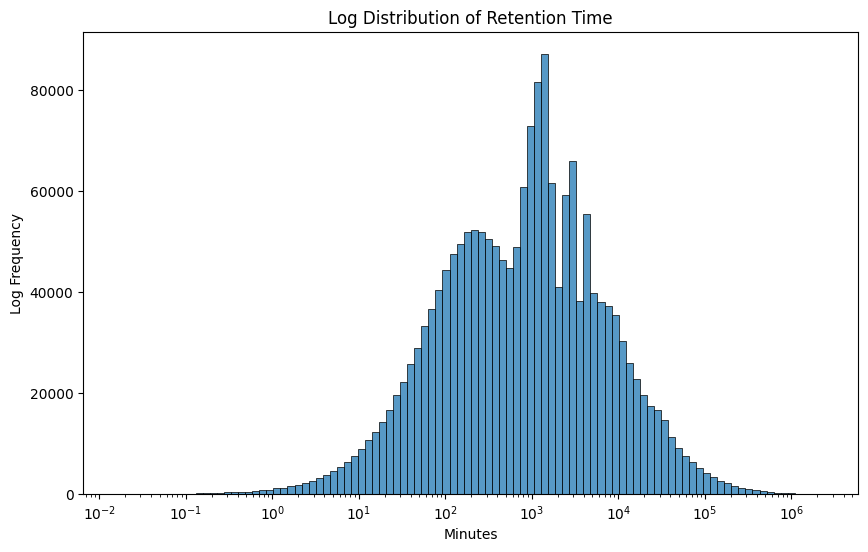

In [44]:
plt.figure(figsize=(10,6))
sns.histplot(retention['retention_minutes'], bins=100, log_scale=True)

plt.title("Log Distribution of Retention Time")
plt.xlabel("Minutes")
plt.ylabel("Log Frequency")
plt.show()


In [21]:
transactions['next_amount'] = transactions.groupby('account_id')['amount'].shift(-1)
transactions['next_time'] = transactions.groupby('account_id')['transaction_timestamp'].shift(-1)

transactions['time_diff_min'] = (transactions['next_time'] - transactions['transaction_timestamp']).dt.seconds/60

rapid_passthrough = transactions[
    (transactions['txn_type']=='C') &
    (transactions['next_amount'] < 0) &
    (transactions['time_diff_min'] < 60)
]

rapid_passthrough.head()


,transaction_id,account_id,transaction_timestamp,mcc_code,channel,amount,txn_type,counterparty_id,round_amount,next_amount,next_time,time_diff_min
899908,TXN_00059307,ACCT_000284,2022-10-11 18:13:45,5682,UPC,1000.00,C,CP_029084,True,-93.63,2022-10-11 18:56:55,43.166667
1033164,TXN_00056216,ACCT_000284,2022-12-31 20:19:59,5682,MCR,55898.34,C,CP_015597,False,-217.29,2022-12-31 21:04:32,44.550000
1694812,TXN_00058420,ACCT_000284,2023-08-01 17:37:42,5651,UPD,11.89,C,CP_052185,False,-11.52,2023-08-01 17:43:09,5.450000
2339521,TXN_00095907,ACCT_000430,2023-11-24 13:11:34,9355,IFD,7500.00,C,CP_079209,False,-344.92,2023-11-24 13:14:08,2.566667
6618423,TXN_00097066,ACCT_000430,2025-04-15 10:58:56,5905,UPD,132.48,C,CP_008351,False,-600.00,2025-04-15 11:27:28,28.533333


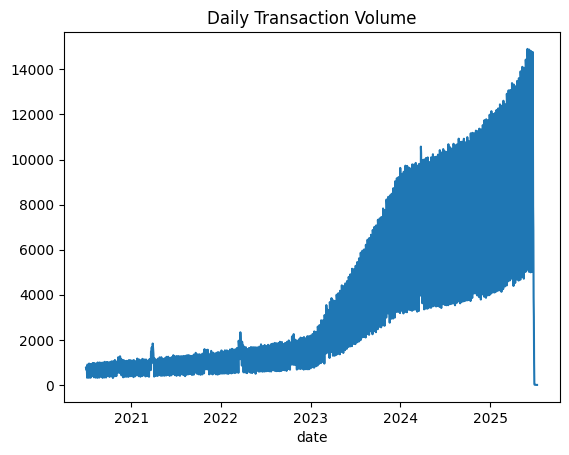

In [22]:
transactions['date'] = transactions['transaction_timestamp'].dt.date
daily_txn = transactions.groupby('date').size()

daily_txn.plot()
plt.title("Daily Transaction Volume")
plt.show()


In [23]:
transactions['month'] = transactions['transaction_timestamp'].dt.month
transactions.groupby('month').size()


month
1     646777
2     610050
3     716487
4     707691
5     765549
6     721100
7     489326
8     511480
9     511842
10    563062
11    573066
12    608415
dtype: int64

In [24]:
# top suspicious branches
accounts.merge(labels, on="account_id") \
        .groupby('branch_code')['is_mule'].mean() \
        .sort_values(ascending=False).head(10)


branch_code
4507    1.0
8175    1.0
3070    1.0
6921    1.0
4000    1.0
1248    1.0
7127    1.0
5986    1.0
2204    1.0
7077    1.0
Name: is_mule, dtype: float64

## 🧠 Key Insights

### 🔎 Behavioral Patterns Observed

✔ Mule accounts show significantly higher transaction velocity  
✔ Rapid credit → debit cycles are common  
✔ High counterparty diversity indicates fund routing behavior  
✔ Structuring near ₹50,000 threshold observed  
✔ Round amount transactions occur disproportionately  

### ⚠️ Risk Indicators

- newly opened accounts with high activity  
- sudden bursts after inactivity  
- unusually high flows relative to balance  

These patterns align with known money mule typologies.


## 🏆 Conclusion

The exploratory analysis reveals strong behavioral differences between mule and legitimate accounts.

Transaction dynamics, network patterns, and structuring behaviors provide meaningful indicators for mule detection.

These insights will guide feature engineering and predictive modeling.

---
